# Data project

Importing libaries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import pandas as pd
import pydst
dst = pydst.Dst(lang='en')

## Importing and cleaning the data

We import data from Statistics Denmark with their API package pydst, and inspect the data structure.

In [2]:
# Importing MPK13
MPK13_true = dst.get_data(table_id = 'MPK13', variables={'TYPE':['*'], 'TID': ['*']})
# Inspecting data structure
MPK13_true.head()

,TYPE,TID,INDHOLD
0,Total (OMXC end December 1995 = 100),2019M08,858
1,Energy,2019M08,3906
2,Materials,2019M08,1100
3,Industrials,2019M08,1416
4,Consumer discretions,2019M08,2100


Now that we're aware of the data structure, we create columns and name them. 

In [3]:
# Creating columns
columns_dict = {}
columns_dict['TYPE'] = 'variable'
columns_dict['TID'] = 'month'
columns_dict['INDHOLD'] = 'value'

# Creating a dictonary for the variables we want to analyze
var_dict = {} # var is for variable
var_dict['OMXC 20 Cap (28th November 2011 = 400)'] = 'OMX' #Benchmark index
var_dict['Industrials'] = 'Industrials'
var_dict['Financials'] = 'Financials'
var_dict['Information technology'] = 'IT'

In [4]:
# Naming columns
MPK13_true.rename(columns=columns_dict,inplace=True)

for key,value in var_dict.items():
   MPK13_true.variable.replace(key,value,inplace=True)

We're now cleaning the data by limiting data to the necessary variables. We ommit any variables which are not included in the variable dictionary. 

In [5]:
# Limiting the variables to necessary ones
I = False

MPK13_true['value'].replace('..','0',inplace=True)
for key,value in var_dict.items():
    I = I | (MPK13_true.variable == value)
MPK13_true = MPK13_true[I]

MPK13_true.value = MPK13_true.value.astype('float')

In [6]:
# Investigating the data structure 
MPK13_true.head()

,variable,month,value
3,Industrials,2019M08,1416.0
7,Financials,2019M08,1451.0
8,IT,2019M08,5507.0
10,OMX,2019M08,1140.0
18,Industrials,2019M03,1426.0


The data comes with a 0,..,N index structure. As we have time series data, captured every month, we change the index to month. 

In [7]:
# Reindexing to the date, such that we have time series data
mpk13 = MPK13_true.set_index('month')
mpk13.head()

,variable,value
month,,
2019M08,Industrials,1416.0
2019M08,Financials,1451.0
2019M08,IT,5507.0
2019M08,OMX,1140.0
2019M03,Industrials,1426.0


The variables are still in rows, and not by a column structure, so we pivot the table, such that every variable has a column, with their values in the rows.

In [8]:
# Adding columns for variables
res = mpk13.pivot(columns='variable', values='value')
res.tail()

variable,Financials,IT,Industrials,OMX
month,,,,
2019M10,1506.0,5475.0,1479.0,1153.0
2019M11,1508.0,6199.0,1610.0,1221.0
2019M12,1639.0,6613.0,1661.0,1256.0
2020M01,1690.0,6640.0,1534.0,1285.0
2020M02,1564.0,6104.0,1356.0,1229.0


## Analysis
We calculate growth rates and average monthly growth rates. We create columns for them in the dataframe, such that we can display it all in one table. We display the table from 2013 to 2020, as OMX is the only variable with data prior to 2013. We do this by only displaying 12 years and 2 months of data.


The monthly growth rate is calculated as:
$$\left( \frac{x_{t}-x_{t-1}}{x_{t-1}} \right) \times 100$$

The average monthly growth rate is calculated as:
$$\left( \left( \frac{x_{T}}{x_{0}} \right) ^ \frac{1}{T} -1 \right) \times 100$$

With month '0' being January 2013 and month 'T' being February 2020

In [9]:
# Calculating monthly growth rates and appending to dataframe
for i,(columnname, columndata) in enumerate(res.iteritems()) : # We are creating a loop which takes the index, name & data from each column
    if i > 3 : # If we reach beyond index 3 which is the last column in the original dataframe we stop the iteration
        StopIteration # Boundary such that the dataframe size does not increase everytime we run the code
    else : # Percentage growth calculation
        res[columnname + ' growth rate'] = ((columndata - columndata.shift()) / columndata.shift()) * 100 

# Calculating the avg. monthly growth rates for each index
for i,(columnname, columndata) in enumerate(res.iteritems()) : # We are iterating the same way as before
    if i > 3 : # Setting our boundary
        StopIteration
    else : # Avg. growth calculation during 12*7+2-1 months. Corresponding to 7 years and 2 months, and subtracting month '0'
        res[columnname + ' avg. monthly growth rate'] = ((columndata['2020M02'] / columndata['2013M01']) ** (1 / (12*7+2-1)) - 1) * 100 

#Displaying the table
res.tail(12*7+2) # 7 years of 12 months plus 2 months of 2020

variable,Financials,IT,Industrials,OMX,Financials growth rate,IT growth rate,Industrials growth rate,OMX growth rate,Financials avg. monthly growth rate,IT avg. monthly growth rate,Industrials avg. monthly growth rate,OMX avg. monthly growth rate
month,,,,,,,,,,,,
2013M01,1098.0,1358.0,977.0,554.0,inf,inf,inf,inf,0.417051,1.783879,0.386401,0.941809
2013M02,1138.0,1496.0,1031.0,575.0,3.642987,10.162003,5.527124,3.790614,0.417051,1.783879,0.386401,0.941809
2013M03,1148.0,1586.0,1026.0,572.0,0.878735,6.016043,-0.484966,-0.521739,0.417051,1.783879,0.386401,0.941809
2013M04,1194.0,1667.0,949.0,566.0,4.006969,5.107188,-7.504873,-1.048951,0.417051,1.783879,0.386401,0.941809
2013M05,1237.0,1768.0,958.0,581.0,3.601340,6.058788,0.948367,2.650177,0.417051,1.783879,0.386401,0.941809
...,...,...,...,...,...,...,...,...,...,...,...,...
2019M10,1506.0,5475.0,1479.0,1153.0,-0.986193,1.482854,2.211472,0.786713,0.417051,1.783879,0.386401,0.941809
2019M11,1508.0,6199.0,1610.0,1221.0,0.132802,13.223744,8.857336,5.897658,0.417051,1.783879,0.386401,0.941809
2019M12,1639.0,6613.0,1661.0,1256.0,8.687003,6.678497,3.167702,2.866503,0.417051,1.783879,0.386401,0.941809


The data frame above shows monthly growth rate by sector from 2013Q1 to 2020Q2, this is useful for monthly inspection of sector performances. To obtain a clear picture of the perfomances of the sectors, we calculate the total growth rates by sector and compare them to the benchmark.

The total growth is calculated as:
$$\left( \frac{x_{T}-x_{0}}{x_{0}} \right) \times 100$$

In [10]:
# Title
print("Total growth by sector:")

# Calculating the total growth for each index
for i,(columnname, columndata) in enumerate(res.iteritems()) : # We are iterating the same way as before
    if i > 3 : # Setting our boundary
        StopIteration
    else : # Total growth calculation
        totalgrowth = ((columndata['2020M02'] / columndata['2013M01']) - 1) * 100 
        print (columnname + ':', round(totalgrowth, 2))

Total growth by sector:
Financials: 42.44
IT: 349.48
Industrials: 38.79
OMX: 121.84


IT is outperforming every other considered sector and the benchmark. IT is the only sector which performs better than the benchmark.

## Illustration of data

To get a clear clear picture of the monthly performance of the sectors, we display the sector index growth and growth rates. 

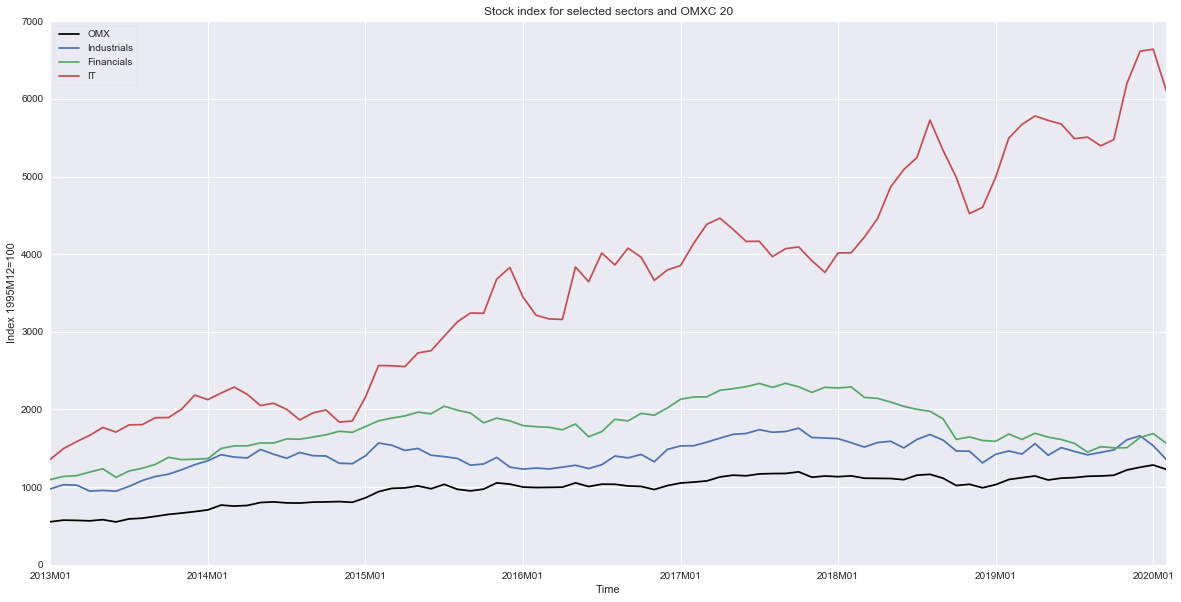

In [11]:
#Initiate figure
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(1,1,1)

#Plotting the data from 2013M01 to 2020M02 and assigning them labels
ax.plot(res['OMX']['2013M01':], color = 'black', label = 'OMX')
ax.plot(res['Industrials']['2013M01':], label = 'Industrials')
ax.plot(res['Financials']['2013M01':], label = 'Financials')
ax.plot(res['IT']['2013M01':], label = 'IT')

#Formatting the visual presentation, customizing the titles and axis', adding a legend and grids
ax.set_xlabel('Time')
ax.set_ylabel('Index 1995M12=100')
ax.set_title('Stock index for selected sectors and OMXC 20')
ax.grid(True)
ax.legend(loc = 'upper left', frameon = True)
ax.set_xlim(0, 85) #In order to make sure there is no "white space" in the ends
ax.set_ylim(0, 7000)
ax.set_xticks(range(0, 86, 12)) #There were too many x-axis tics, so only every twelved tic is shown

All four stock indexes has seen an increase during the period January 2013 to February 2020. The stock index concerning IT has grown the most, and has almost 5 times the value in 2020 compared to 2013. The Industrial and Financial sectors have seen a similiar development, also moving along with the OMX cap. The OMX has not increased nearly as much as the IT stock index, this indicates that the financial and industrial sectors influences OMX the most, but further analysis is required to conclude this.

Text(0.5, 1.0, 'IT')

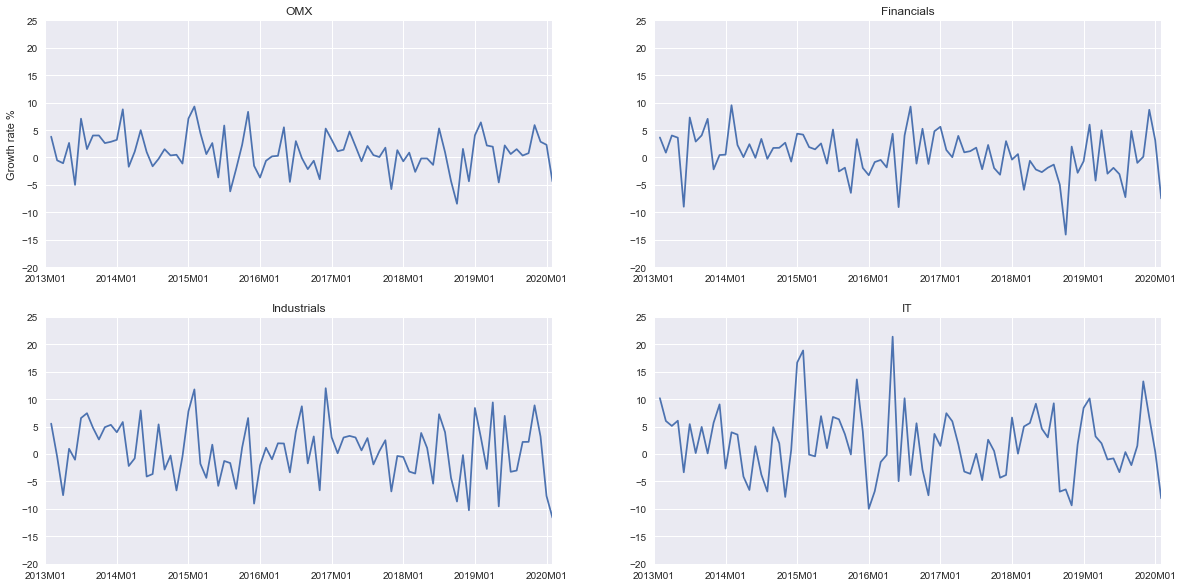

In [13]:
# Illustration of data

#Initiate figure
fig, ax = plt.subplots(2,2, figsize = (20,10))

#Plotting each variable in individual figures
ax[0,0].plot(res['OMX growth rate']['2013M01':])
ax[1,0].plot(res['Industrials growth rate']['2013M01':])
ax[0,1].plot(res['Financials growth rate']['2013M01':])
ax[1,1].plot(res['IT growth rate']['2013M01':])


#Formatting the visual presentation. Setting axis limits, 
ax[0,0].set_ylim(-20, 25)
ax[1,0].set_ylim(-20, 25)
ax[0,1].set_ylim(-20, 25)
ax[1,1].set_ylim(-20, 25)
ax[0,0].set_xlim(0, 85)
ax[1,0].set_xlim(0, 85)
ax[0,1].set_xlim(0, 85)
ax[1,1].set_xlim(0, 85)
ax[0,0].set_xticks(range(0, 86, 12))
ax[1,0].set_xticks(range(0, 86, 12))
ax[0,1].set_xticks(range(0, 86, 12))
ax[1,1].set_xticks(range(0, 86, 12))
ax[0,0].set_ylabel('Growth rate %')
ax[0,0].set_title('OMX')
ax[1,0].set_title('Industrials')
ax[0,1].set_title('Financials')
ax[1,1].set_title('IT')

These figures shows the monthly growth of the four stock indexes. The IT stock index has the biggest outliers, but also the highest monthly average growth of 1.78 hence the first table in Analysis above. The financial and industrial stock indexes both fluctuates around an average monthly growth of 0.4 almost. The OMX has an average monthly growth rate of 0.94. This indicates that the growth in OMXC 20 cap is produced by the growth in IT, but this also needs a further investigation to conclude.

## Conclusion
Information technology is the driver of the benchmark index, outperforming the other sectors significantly. The data looks as expected, as media has discussed the emerging IT industry for a while. It's interesting how much of a driver IT is for the OMXC, which becomes clear in the *Total growth by sector* section.  